This code prices interest rate swaps based on a Nelson-Siegel-Svensson model using historical yields data.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [107]:
# Load CSV files
df_2015 = pd.read_csv('daily_treasury_rates_2015.csv', parse_dates=['Date'])
df_2016 = pd.read_csv('daily_treasury_rates_2016.csv', parse_dates=['Date'])
df_2017 = pd.read_csv('daily_treasury_rates_2017.csv', parse_dates=['Date'])
df_2018 = pd.read_csv('daily_treasury_rates_2018.csv', parse_dates=['Date'])
df_2019 = pd.read_csv('daily_treasury_rates_2019.csv', parse_dates=['Date'])
df_2020 = pd.read_csv('daily_treasury_rates_2020.csv', parse_dates=['Date'])
df_2021 = pd.read_csv('daily_treasury_rates_2021.csv', parse_dates=['Date'])
df_2022 = pd.read_csv('daily_treasury_rates_2022.csv', parse_dates=['Date'])
df_2023 = pd.read_csv('daily_treasury_rates_2023.csv', parse_dates=['Date'])
df_2024 = pd.read_csv('daily_treasury_rates_2024.csv', parse_dates=['Date'])

# Combine and sort the dataframes
df_combined = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]).sort_values(by='Date', ascending=False).reset_index(drop=True)

#df_combined = pd.concat([df_2023]).sort_values(by='Date').reset_index(drop=True)


# Convert rates to numeric and dates to datetime
for col in df_combined.columns[1:]:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

df_combined = df_combined.drop(['2 Mo', '4 Mo'], axis=1) # Remove 2 and 4 Month yields, as not necessary for this project

In [108]:
def nss_model(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    # Handle the case when t is 0 to prevent division by zero
    t_is_zero = t == 0
    t = np.where(t_is_zero, 1, t)  # Replace 0 with 1 to avoid division by zero, then correct it later
    
    term1 = beta_0
    term2 = beta_1 * ((1 - np.exp(-t / tau_1)) / (t / tau_1))
    term3 = beta_2 * (((1 - np.exp(-t / tau_1)) / (t / tau_1)) - np.exp(-t / tau_1))
    term4 = beta_3 * (((1 - np.exp(-t / tau_2)) / (t / tau_2)) - np.exp(-t / tau_2))
    
    # Correct the values where t was originally 0
    term2 = np.where(t_is_zero, beta_1 * tau_1, term2)  # Apply L'Hôpital's rule for limit as t -> 0
    term3 = np.where(t_is_zero, 0, term3)  # The limit as t -> 0 for this term is 0
    term4 = np.where(t_is_zero, 0, term4)  # The limit as t -> 0 for this term is also 0
    
    return term1 + term2 + term3 + term4

def sse_nss(params, maturities, observed_rates):
    beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params
    fitted_rates = nss_model(maturities, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2)
    return np.sum((observed_rates - fitted_rates) ** 2)

In [109]:
class InterestRateSwap:
    def __init__(self, notional, fixed_rate, maturity_years, payment_frequency):
        self.notional = notional
        self.fixed_rate = fixed_rate
        self.maturity_years = maturity_years
        self.payment_frequency = payment_frequency

    def discount_factor(self, yield_curve, time):
        """Calculate the discount factor for a given time and yield curve."""
        rate = yield_curve(time)
        return np.exp(-rate * time)

    def calculate_pv(self, yield_curve, payment_times):
        """Calculate the present value of fixed leg cash flows."""
        cash_flows = np.array([self.notional * self.fixed_rate / self.payment_frequency 
                               for _ in payment_times])
        
        discount_factors = np.array([self.discount_factor(yield_curve, t) 
                                     for t in payment_times])
        
        pv = np.sum(cash_flows * discount_factors)
        return pv

    def floating_leg_pv(self, yield_curve, payment_times):
        """Calculate the present value of floating leg cash flows."""
        # For simplicity, I have assumed the floating rate resets are equal to the forward rates
        # In practice, this would be derived from the yield curve or market forward rates
        forward_rates = np.diff(np.log([self.discount_factor(yield_curve, t) for t in payment_times]))
        cash_flows = np.array([self.notional * (np.exp(forward_rate) - 1) for forward_rate in forward_rates])
        
        discount_factors = np.array([self.discount_factor(yield_curve, t) 
                                     for t in payment_times[1:]])
        
        pv = np.sum(cash_flows * discount_factors)
        return pv

    def net_pv(self, yield_curve, payment_times):
        """Calculate the net present value of the swap."""
        fixed_leg_pv = self.calculate_pv(yield_curve, payment_times)
        floating_leg_pv = self.floating_leg_pv(yield_curve, payment_times)
        return fixed_leg_pv - floating_leg_pv

Explanation of NSS parameters:

beta_0: This parameter represents the long-term level of the yield curve. As maturity goes to infinity, the yield curve will approach beta_0. It can be thought of as the average long-term yield if the yield curve were flat.

beta_1: This parameter captures the short-term yield curve slope. It influences the yield curve's deviation from beta_0 at short maturities. A positive beta_1 would typically indicate an upward-sloping (normal) yield curve at the short end, while a negative beta_1 would indicate a downward-sloping (inverted) yield curve.

beta_2: This parameter controls the medium-term hump shape of the yield curve. It allows the yield curve to have a turning point. The sign and magnitude of beta_2 determine the direction and size of the hump.

beta_3: This is an additional parameter that the Svensson model adds to the Nelson-Siegel model. It provides extra flexibility, particularly at the long end of the yield curve, allowing the curve to capture more complex shapes.

tau_1: This is the decay factor for beta_1 and beta_2. It determines how quickly the effects of these parameters diminish as maturity increases. A smaller tau_1 means the effects wear off more quickly, making the yield curve reach beta_0 faster.

tau_2: This is the decay factor for beta_3 and is exclusive to the Svensson extension. It plays a similar role to tau_1 but for the beta_3 term, determining how quickly its effect diminishes.

In [110]:
# Given data
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
dates_to_visualise = ['2020-02-07', '2021-07-08', '2024-02-09']  # List of dates to process
initial_guess = [0.5, 1, 2, 0.7, 3, 7]  # Initial parameter guesses
notional = 1000000
fixed_rate = 0.05
maturity_years = 1
payment_frequency = 4  # Number of yearly payments

Fitted parameters for 2020-02-07: [ 0.02461898 -0.00856062 -0.01520649 -0.00759148  3.05486783  7.12724616]
The net present value of the swap for 2020-02-07 is: $60,296.29


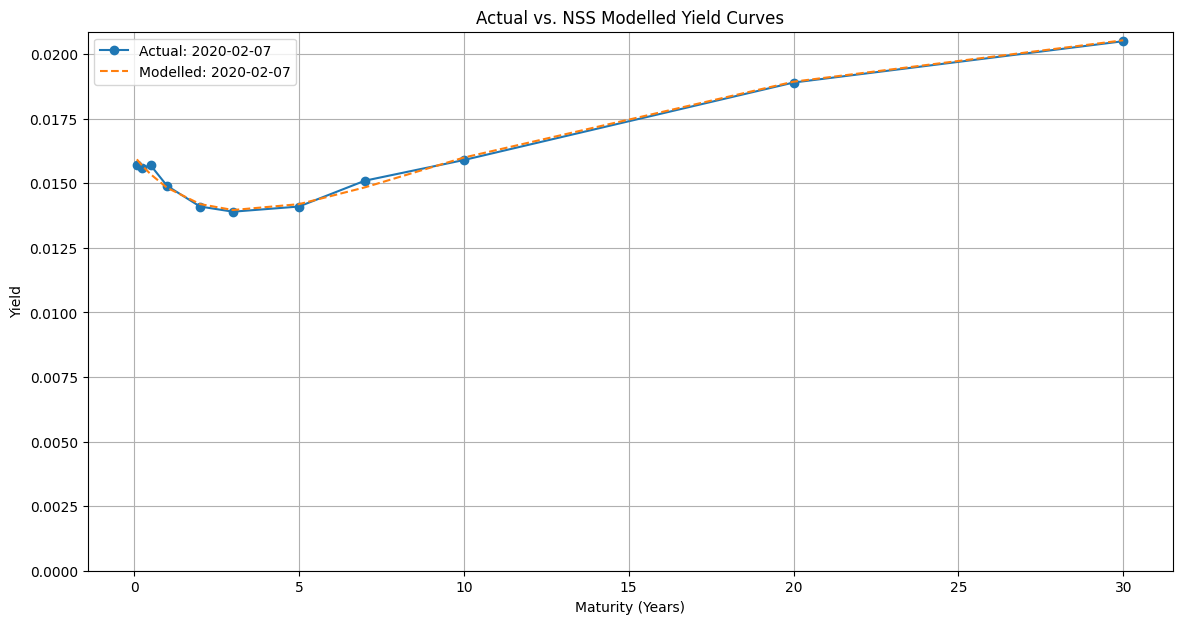

Fitted parameters for 2021-07-08: [ 0.01477219 -0.01421597 -0.03239833  0.03978666  3.07092692  7.12958807]
The net present value of the swap for 2021-07-08 is: $50,760.39


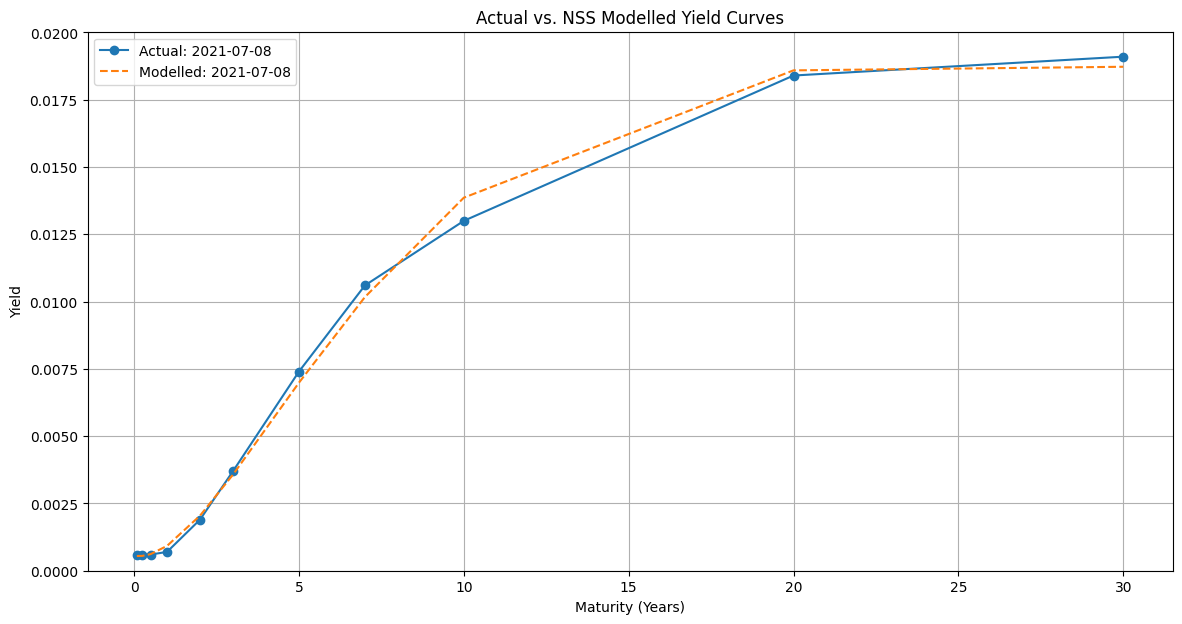

Fitted parameters for 2024-02-09: [ 0.03980795  0.01595984 -0.04788049  0.03412294  3.04114454  7.12859439]
The net present value of the swap for 2024-02-09 is: $82,715.61


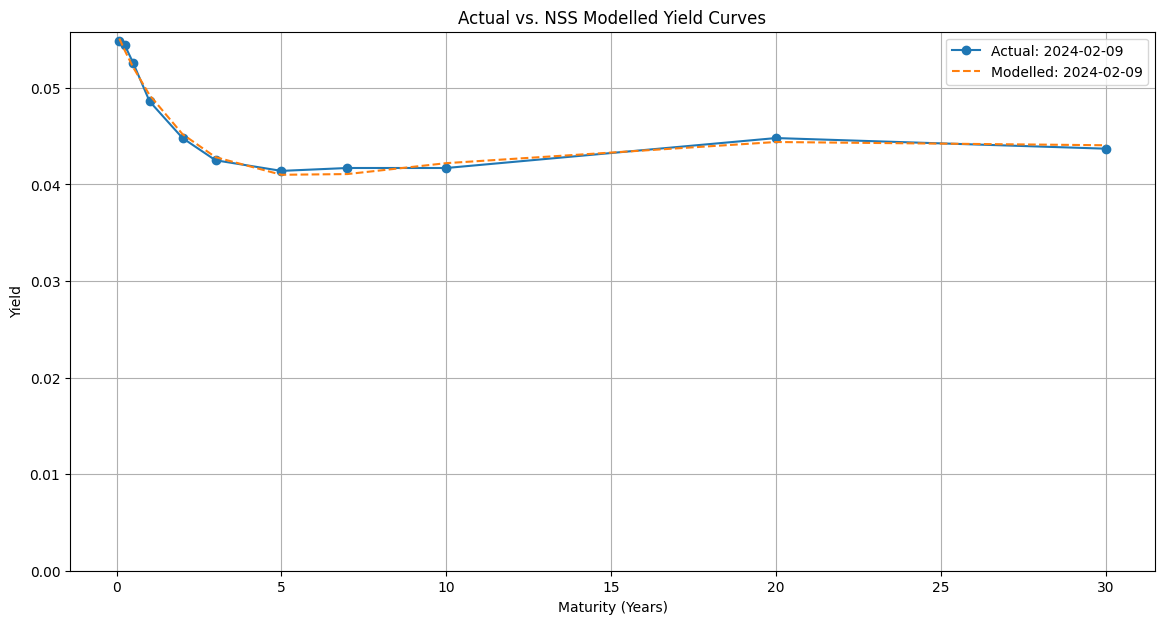

In [111]:
# Processing and plotting for each date
for date in dates_to_visualise:
    date_df = df_combined[df_combined['Date'] == pd.to_datetime(date)]
    if not date_df.empty:
        # Extract rates for the chosen date
        chosen_date_rates = date_df.iloc[0, 1:].values / 100

        # Optimisation to fit the model parameters
        result = minimize(sse_nss, initial_guess, args=(maturities, chosen_date_rates), method='L-BFGS-B')
        params_fitted = result.x

        print(f"Fitted parameters for {date}: {params_fitted}")

        # Swap valuation
        swap = InterestRateSwap(notional, fixed_rate, maturity_years, payment_frequency)
        yield_curve_nss = lambda t: nss_model(t, *params_fitted)
        payment_times = np.linspace(1/payment_frequency, maturity_years, int(maturity_years * payment_frequency))
        net_swap_pv = swap.net_pv(yield_curve_nss, payment_times)
        print(f"The net present value of the swap for {date} is: ${net_swap_pv:,.2f}")

        # Plotting
        plt.figure(figsize=(14, 7))
        actual_rates = chosen_date_rates
        model_rates = [yield_curve_nss(t) for t in maturities]
        plt.plot(maturities, actual_rates, marker='o', label=f'Actual: {date}')
        plt.plot(maturities, model_rates, label=f'Modelled: {date}', linestyle='--')
        plt.title('Actual vs. NSS Modelled Yield Curves')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.ylim(bottom=0)
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print(f"No data available for {date}")